In [1]:
!nvidia-smi

Sun Mar 19 23:32:47 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.18                 Driver Version: 531.18       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070 Ti    WDDM | 00000000:0B:00.0  On |                  N/A |
| 53%   46C    P0               79W / 310W|    903MiB /  8192MiB |      4%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## T5 Model Version and Tokenizer

In [2]:
from transformers import AutoTokenizer, T5ForConditionalGeneration

### Version

In [3]:
CKPT = 't5-base'

### Model and Tokenizer

In [4]:
model = T5ForConditionalGeneration.from_pretrained(CKPT)
tokenizer = AutoTokenizer.from_pretrained(CKPT)

c:\Users\Huang\anaconda3\envs\text2sql\lib\site-packages\transformers\models\t5\tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


## Data Loading and Preprocessing

In [5]:
import json
import pandas as pd
from datasets import load_dataset, Dataset

### Loading

In [6]:
with open('data\cosql_dataset\sql_state_tracking\cosql_train.json', 'r') as f:
    train_data = json.load(f)
with open('data\cosql_dataset\sql_state_tracking\cosql_dev.json', 'r') as f:
    test_data = json.load(f)

In [7]:
def process_cosql(dataset, scope: str) -> pd.DataFrame:
    scope_valid = ['all', 'final', 'interaction']
    if scope not in scope_valid:
        raise ValueError(f'scope must be one of {scope_valid}')

    processed_input = []
    processed_target = []
    for dialog in dataset:
        if scope in ['all', 'final']:
            processed_input.append(dialog['final']['utterance'])
            processed_target.append(dialog['final']['query'])
        if scope in ['all', 'interaction']:
            for turn in dialog['interaction']:
                processed_input.append(turn['utterance'])
                processed_target.append(turn['query'])
                
    processed_dataset = pd.DataFrame({
        'input': processed_input,
        'target': processed_target
    })

    return processed_dataset

In [8]:
train_df_final = process_cosql(train_data, scope='final')
test_df_final = process_cosql(test_data, scope='final')

In [9]:
train_dataset_final = Dataset.from_pandas(train_df_final)
test_dataset_final = Dataset.from_pandas(test_df_final)

### Exploration

In [10]:
train_dataset_final[0]

{'input': 'Find the name of the department which has the highest average salary of professors.',
 'target': 'SELECT dept_name FROM instructor GROUP BY dept_name ORDER BY avg(salary) DESC LIMIT 1'}

In [11]:
def format_eda_dataset(example):
    return {'input': example['input'], 'target': example['target']}

In [12]:
eda_dataset = train_dataset_final.map(format_eda_dataset, remove_columns=train_dataset_final.column_names)

Map:   0%|          | 0/2159 [00:00<?, ? examples/s]

In [13]:
eda_dataset[0]

{'input': 'Find the name of the department which has the highest average salary of professors.',
 'target': 'SELECT dept_name FROM instructor GROUP BY dept_name ORDER BY avg(salary) DESC LIMIT 1'}

In [14]:
# map article and summary len to dict as well as if sample is longer than 512 tokens
def map_to_length(x):
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained('t5-base')
    x["input_len"] = len(tokenizer(x["input"]).input_ids)
    x["input_longer_256"] = int(x["input_len"] > 256)
    x["input_longer_128"] = int(x["input_len"] > 128)
    x["input_longer_64"] = int(x["input_len"] > 64)
    x["out_len"] = len(tokenizer(x["target"]).input_ids)
    x["out_longer_256"] = int(x["out_len"] > 256)
    x["out_longer_128"] = int(x["out_len"] > 128)
    x["out_longer_64"] = int(x["out_len"] > 64)
    return x

data_stats = eda_dataset.map(map_to_length, num_proc=4)


Map (num_proc=4):   0%|          | 0/2159 [00:00<?, ? examples/s]

In [15]:
sample_size = len(eda_dataset)

print(
    "Input Mean: {} \n%-Input > 256:{} \n%-Input > 128:{} \n%-Input > 64:{} \nOutput Mean:{} \n%-Output > 256:{} \n%-Output > 128:{} \n%-Output > 64:{}".format(
        sum(data_stats["input_len"]) / sample_size,
        sum(data_stats["input_longer_256"]) / sample_size,
        sum(data_stats["input_longer_128"]) / sample_size,
        sum(data_stats["input_longer_64"]) / sample_size,   
        sum(data_stats["out_len"]) / sample_size,
        sum(data_stats["out_longer_256"]) / sample_size,
        sum(data_stats["out_longer_128"]) / sample_size,
        sum(data_stats["out_longer_64"]) / sample_size,
    )
)

Input Mean: 17.82260305697082 
%-Input > 256:0.0 
%-Input > 128:0.0 
%-Input > 64:0.0 
Output Mean:54.780917091245946 
%-Output > 256:0.0 
%-Output > 128:0.020842982862436313 
%-Output > 64:0.3228346456692913


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

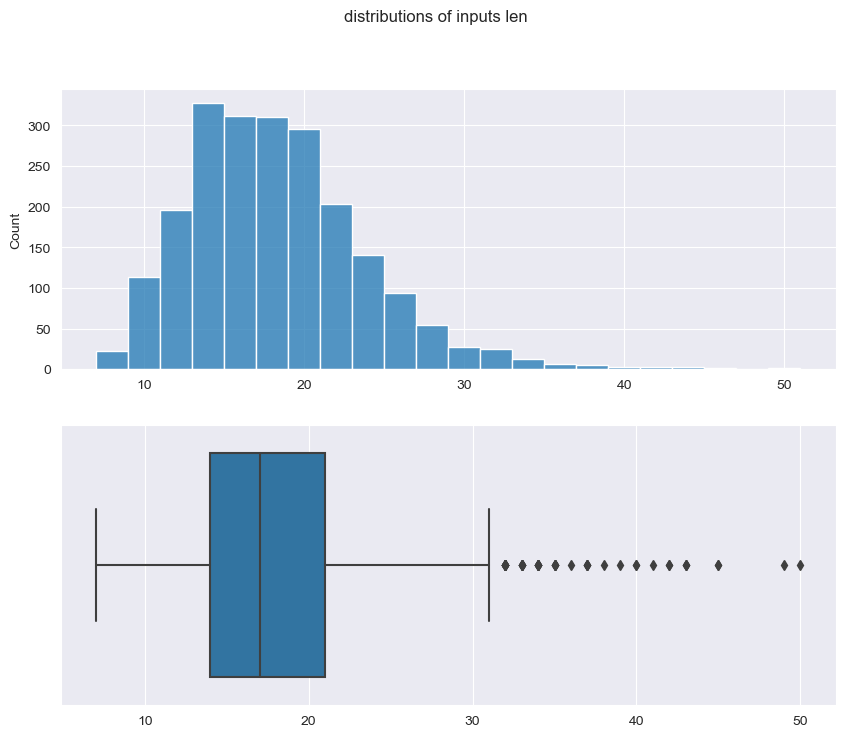

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8));
sns.histplot(x=data_stats["input_len"], ax=ax[0], binwidth=2);
sns.boxplot(x=data_stats["input_len"], ax=ax[1]);
fig.suptitle('distributions of inputs len');

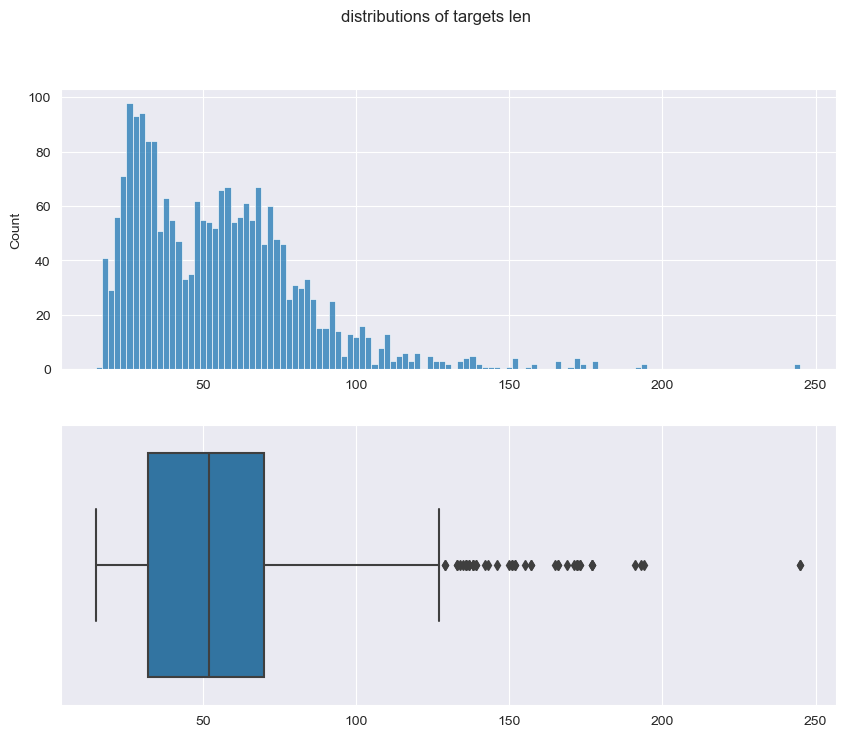

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8));
sns.histplot(x=data_stats["out_len"], ax=ax[0], binwidth=2);
sns.boxplot(x=data_stats["out_len"], ax=ax[1]);
fig.suptitle('distributions of targets len');

### Transformation

In [10]:
def format_dataset(example):
    return {'input': 'translate to SQL: ' + example['input'], 'target': example['target']}

In [11]:
train_dataset = train_dataset_final.map(format_dataset, remove_columns=train_dataset_final.column_names)
test_dataset = test_dataset_final.map(format_dataset, remove_columns=test_dataset_final.column_names)

Map:   0%|          | 0/2159 [00:00<?, ? examples/s]

Map:   0%|          | 0/293 [00:00<?, ? examples/s]

### Tokenization

In [12]:
# tokenize the examples
def convert_to_features(example_batch):
    input_encodings = tokenizer.batch_encode_plus(example_batch['input'], pad_to_max_length=True, max_length=64)
    target_encodings = tokenizer.batch_encode_plus(example_batch['target'], pad_to_max_length=True, max_length=64)

    encodings = {
        'input_ids': input_encodings['input_ids'], 
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids'],
        'decoder_attention_mask': target_encodings['attention_mask']
    }

    return encodings

In [13]:
train_dataset = train_dataset.map(convert_to_features, batched=True, remove_columns=train_dataset.column_names)
test_dataset = test_dataset.map(convert_to_features, batched=True, remove_columns=test_dataset.column_names)

columns = ['input_ids', 'attention_mask', 'labels', 'decoder_attention_mask']

train_dataset.set_format(type='torch', columns=columns)
test_dataset.set_format(type='torch', columns=columns)

Map:   0%|          | 0/2159 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\Huang\anaconda3\envs\text2sql\lib\site-packages\transformers\tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Map:   0%|          | 0/293 [00:00<?, ? examples/s]

## Model Training

In [14]:
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments

### Trainer Args

In [15]:
# set training arguments - Feel free to adapt it
training_args = Seq2SeqTrainingArguments(
    output_dir="output/t5_base_finetuned_cosql",
    per_device_train_batch_size=16,
    num_train_epochs=5,
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_strategy="epoch",
    # logging_steps=100,
    save_strategy="epoch",
    #save_steps=1000,
    #eval_steps=1000,
    overwrite_output_dir=True,
    save_total_limit=3,
    load_best_model_at_end=True,
    push_to_hub=False,
    #fp16=True, 
    log_level="info",
    logging_dir="output/t5_base_finetuned_cosql/log",
    report_to="all",
)

### Metrics

In [16]:
from datasets import load_metric
import evaluate
rouge = load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

C:\Users\Huang\AppData\Local\Temp\ipykernel_15712\1943893938.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric("rouge")


### Trainer

In [17]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [18]:
# trainer.evaluate()

In [19]:
trainer.train()

c:\Users\Huang\anaconda3\envs\text2sql\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2159
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 675
  Number of trainable parameters = 222903552


  0%|          | 0/675 [00:00<?, ?it/s]

***** Running Evaluation *****
  Num examples = 293
  Batch size = 16
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



{'loss': 1.8091, 'learning_rate': 4e-05, 'epoch': 1.0}


  0%|          | 0/19 [00:00<?, ?it/s]

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_

{'eval_loss': 0.8362610340118408, 'eval_rouge2_precision': 0.3254, 'eval_rouge2_recall': 0.1598, 'eval_rouge2_fmeasure': 0.2065, 'eval_runtime': 9.0948, 'eval_samples_per_second': 32.216, 'eval_steps_per_second': 2.089, 'epoch': 1.0}


Model weights saved in output/t5_base_finetuned_cosql\checkpoint-135\pytorch_model.bin
Deleting older checkpoint [output\t5_base_finetuned_cosql\checkpoint-810] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 293
  Batch size = 16
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



{'loss': 0.7877, 'learning_rate': 3e-05, 'epoch': 2.0}


  0%|          | 0/19 [00:00<?, ?it/s]

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_

{'eval_loss': 0.7188637852668762, 'eval_rouge2_precision': 0.3717, 'eval_rouge2_recall': 0.179, 'eval_rouge2_fmeasure': 0.2323, 'eval_runtime': 8.9862, 'eval_samples_per_second': 32.606, 'eval_steps_per_second': 2.114, 'epoch': 2.0}


Model weights saved in output/t5_base_finetuned_cosql\checkpoint-270\pytorch_model.bin
Deleting older checkpoint [output\t5_base_finetuned_cosql\checkpoint-945] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 293
  Batch size = 16
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



{'loss': 0.6618, 'learning_rate': 2e-05, 'epoch': 3.0}


  0%|          | 0/19 [00:00<?, ?it/s]

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_

{'eval_loss': 0.6823301315307617, 'eval_rouge2_precision': 0.3877, 'eval_rouge2_recall': 0.1828, 'eval_rouge2_fmeasure': 0.2388, 'eval_runtime': 8.6609, 'eval_samples_per_second': 33.83, 'eval_steps_per_second': 2.194, 'epoch': 3.0}


Model weights saved in output/t5_base_finetuned_cosql\checkpoint-405\pytorch_model.bin
Deleting older checkpoint [output\t5_base_finetuned_cosql\checkpoint-1080] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 293
  Batch size = 16
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



{'loss': 0.6002, 'learning_rate': 1e-05, 'epoch': 4.0}


  0%|          | 0/19 [00:00<?, ?it/s]

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_

{'eval_loss': 0.6694309115409851, 'eval_rouge2_precision': 0.3969, 'eval_rouge2_recall': 0.1896, 'eval_rouge2_fmeasure': 0.2474, 'eval_runtime': 8.746, 'eval_samples_per_second': 33.501, 'eval_steps_per_second': 2.172, 'epoch': 4.0}


Model weights saved in output/t5_base_finetuned_cosql\checkpoint-540\pytorch_model.bin
Deleting older checkpoint [output\t5_base_finetuned_cosql\checkpoint-135] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 293
  Batch size = 16
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



{'loss': 0.5736, 'learning_rate': 0.0, 'epoch': 5.0}


  0%|          | 0/19 [00:00<?, ?it/s]

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_

{'eval_loss': 0.6636595129966736, 'eval_rouge2_precision': 0.3991, 'eval_rouge2_recall': 0.1913, 'eval_rouge2_fmeasure': 0.2488, 'eval_runtime': 7.6568, 'eval_samples_per_second': 38.267, 'eval_steps_per_second': 2.481, 'epoch': 5.0}


Model weights saved in output/t5_base_finetuned_cosql\checkpoint-675\pytorch_model.bin
Deleting older checkpoint [output\t5_base_finetuned_cosql\checkpoint-270] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from output/t5_base_finetuned_cosql\checkpoint-675 (score: 0.6636595129966736).


{'train_runtime': 235.1846, 'train_samples_per_second': 45.9, 'train_steps_per_second': 2.87, 'train_loss': 0.8864944231951678, 'epoch': 5.0}


TrainOutput(global_step=675, training_loss=0.8864944231951678, metrics={'train_runtime': 235.1846, 'train_samples_per_second': 45.9, 'train_steps_per_second': 2.87, 'train_loss': 0.8864944231951678, 'epoch': 5.0})

In [20]:
trainer.save_model()

Saving model checkpoint to output/t5_base_finetuned_cosql
Configuration saved in output/t5_base_finetuned_cosql\config.json
Configuration saved in output/t5_base_finetuned_cosql\generation_config.json
Model weights saved in output/t5_base_finetuned_cosql\pytorch_model.bin


In [21]:
tokenizer.save_pretrained('output/t5_base_finetuned_cosql')

tokenizer config file saved in output/t5_base_finetuned_cosql\tokenizer_config.json
Special tokens file saved in output/t5_base_finetuned_cosql\special_tokens_map.json
Copy vocab file to output/t5_base_finetuned_cosql\spiece.model


('output/t5_base_finetuned_cosql\\tokenizer_config.json',
 'output/t5_base_finetuned_cosql\\special_tokens_map.json',
 'output/t5_base_finetuned_cosql\\spiece.model',
 'output/t5_base_finetuned_cosql\\added_tokens.json',
 'output/t5_base_finetuned_cosql\\tokenizer.json')

## Model Inference on WikiSQL Test Set

### Fine Tuned Model

In [23]:
CKPT = 'output/t5_base_finetuned_cosql'
model_tuned = T5ForConditionalGeneration.from_pretrained(CKPT)
tokenizer_tuned = AutoTokenizer.from_pretrained(CKPT)

loading configuration file output/t5_base_finetuned_cosql\config.json
Model config T5Config {
  "_name_or_path": "t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "translation_en_to_de": {
    

### Inference Set

In [26]:
test_data[0]['final']['utterance']

{'utterance': 'How many car models are produced by each maker? List the count and the maker full name.',
 'query': 'SELECT Count(*) ,  T2.FullName ,  T2.id FROM MODEL_LIST AS T1 JOIN CAR_MAKERS AS T2 ON T1.Maker  =  T2.Id GROUP BY T2.id;'}

In [27]:
inference_data = test_data

In [28]:
def translate_to_sql(text, tokenizer, model):
    inputs = tokenizer(text, padding='longest', max_length=64, return_tensors='pt')
    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask
    output = model.generate(input_ids, attention_mask=attention_mask, max_length=64)

    return tokenizer.decode(output[0], skip_special_tokens=True)

In [29]:
for i in range(0,100,10):
    print('translate to SQL: ' + inference_data[i]['final']['utterance'])
    print('Predict. :' + translate_to_sql('translate to SQL: ' + inference_data[i]['final']['utterance'], tokenizer=tokenizer_tuned, model=model_tuned))
    print('Expected: ' + inference_data[i]['final']['query'])
    print('=================================\n')
     

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



translate to SQL: How many car models are produced by each maker? List the count and the maker full name.


Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Predict. :SELECT count(*), full_name FROM car WHERE maker_id NOT IN (SELECT maker_id FROM car WHERE maker_id NOT IN)
Expected: SELECT Count(*) ,  T2.FullName ,  T2.id FROM MODEL_LIST AS T1 JOIN CAR_MAKERS AS T2 ON T1.Maker  =  T2.Id GROUP BY T2.id;

translate to SQL: Find the manager name and district of the shop whose number of products is the largest.


Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Predict. :SELECT T1.manager_name, T1.shop_district FROM products AS T1 JOIN products AS T2 ON T1.shop_id = T2.shop_id WHERE T2.product_count = 'largest'
Expected: SELECT manager_name ,  district FROM shop ORDER BY number_products DESC LIMIT 1

translate to SQL: Show distinct names of singers that have songs with sales more than 300000.


Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Predict. :SELECT DISTINCT T1.Name FROM singer AS T1 JOIN song AS T2 ON T1.Song_ID = T2.Song_ID WHERE T2.Sales > 300000
Expected: SELECT DISTINCT T1.Name FROM singer AS T1 JOIN song AS T2 ON T1.Singer_ID  =  T2.Singer_ID WHERE T2.Sales  >  300000

translate to SQL: List the title of all cartoon directed by "Ben Jones" or "Brandon Vietti".


Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Predict. :SELECT title FROM cartoon WHERE cartoon_director = "Ben Jones" OR cartoon_director = "Brandon Vietti"
Expected: SELECT Title FROM Cartoon WHERE Directed_by = "Ben Jones" OR Directed_by = "Brandon Vietti";

translate to SQL: What is the birth date of the poker player with the lowest earnings?


Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Predict. :SELECT birth_date FROM player WHERE earnings = 'lowest'
Expected: SELECT T1.Birth_Date FROM people AS T1 JOIN poker_player AS T2 ON T1.People_ID  =  T2.People_ID ORDER BY T2.Earnings ASC LIMIT 1

translate to SQL: Show distinct names of singers that have songs with sales more than 300000.


Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Predict. :SELECT DISTINCT T1.Name FROM singer AS T1 JOIN song AS T2 ON T1.Song_ID = T2.Song_ID WHERE T2.Sales > 300000
Expected: SELECT DISTINCT T1.Name FROM singer AS T1 JOIN song AS T2 ON T1.Singer_ID  =  T2.Singer_ID WHERE T2.Sales  >  300000

translate to SQL: How many cars have a larger accelerate than the car with the largest horsepower?


Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Predict. :SELECT count(*) FROM car WHERE speed > (SELECT speed FROM car WHERE horsepower >)
Expected: SELECT COUNT(*) FROM CARS_DATA WHERE Accelerate  >  ( SELECT Accelerate FROM CARS_DATA ORDER BY Horsepower DESC LIMIT 1 );

translate to SQL: Who is the first student to register? List the first name, middle name and last name.


Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Predict. :SELECT T1.first_name, T1.mid_name, T1.last_name FROM student AS T1 JOIN student AS T2 ON T1.student_id = T2.student_id WHERE T2.first_name = "Registration"
Expected: SELECT first_name ,  middle_name ,  last_name FROM Students ORDER BY date_first_registered ASC LIMIT 1

translate to SQL: Find the codes of countries that have more than 50 players.


Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Predict. :SELECT country_code FROM player WHERE player_count > 50
Expected: SELECT country_code FROM players GROUP BY country_code HAVING count(*)  >  50

translate to SQL: How many times at most can a course enrollment result show in different transcripts? Also show the course enrollment id.
Predict. :SELECT count(*) FROM Course_Enrollment WHERE course_enrollment_id = 'Current_Enrollment_Results' AND transcript_id = 'Current_Enrollment_id'
Expected: SELECT count(*) ,  student_course_id FROM Transcript_Contents GROUP BY student_course_id ORDER BY count(*) DESC LIMIT 1

